In [20]:
import numpy as np

### A set of relevant constants

In [21]:
pi_square = np.square(np.pi)
small_value = 1e-200

## M-H functions

In [22]:
def factory_sampler(vTheta):
    """
    Build a function that samples a candidate h, given a set of parameters
    from a three normals target distribution.
    Precomputes common factors.
    """
    
    dMu, dGamma, dPhi, dSXi = vTheta
    
    std_xi_square = np.square(dSXi)
    
    hc = 1/std_xi_square + np.square(dPhi)/std_xi_square + 2/pi_square
     
    combined_variance = np.reciprocal(hc)
    combined_std = np.sqrt(combined_variance)
    
    def sampler(previous_h, next_h, current_y):
        """
        The actual sampler fuction. Takes the previous point, the next point, and the data y estimate
        and computes a sample from the jumping distribution.
        """
            
        y_square_log = np.log(np.square(current_y))
        y_contribution = 1.27 + y_square_log - dGamma
        
        uncentered_mean = (previous_h + next_h) * dPhi /std_xi_square + 2 * y_contribution/pi_square
        mean = uncentered_mean * combined_variance
    
        return np.random.normal(mean, combined_std), mean
    
    
    def compute_acc_prob(candidate_h, current_h, current_y, mean):
        """
        Computes the acceptance ratio as likelihood ratio times the jumping distribution ratio
        """
        
        first_diff = (current_h - candidate_h)
        exponentiated = (np.exp(- current_h - dGamma) - np.exp(- candidate_h - dGamma))
        square_diff_y = np.square(current_y - dMu)
        
        likelihood_ratio = 0.5 * (first_diff + exponentiated * square_diff_y)
        
        density_ratio = (np.square(candidate_h - mean) - np.square(current_h - mean))/(2 * combined_variance)
        
        return np.exp(density_ratio + likelihood_ratio)
        
        
    return sampler, compute_acc_prob
    

# Given code


Done in  4.46494722366333


/home/nofishlikeian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:150: RuntimeWarning: invalid value encountered in sqrt


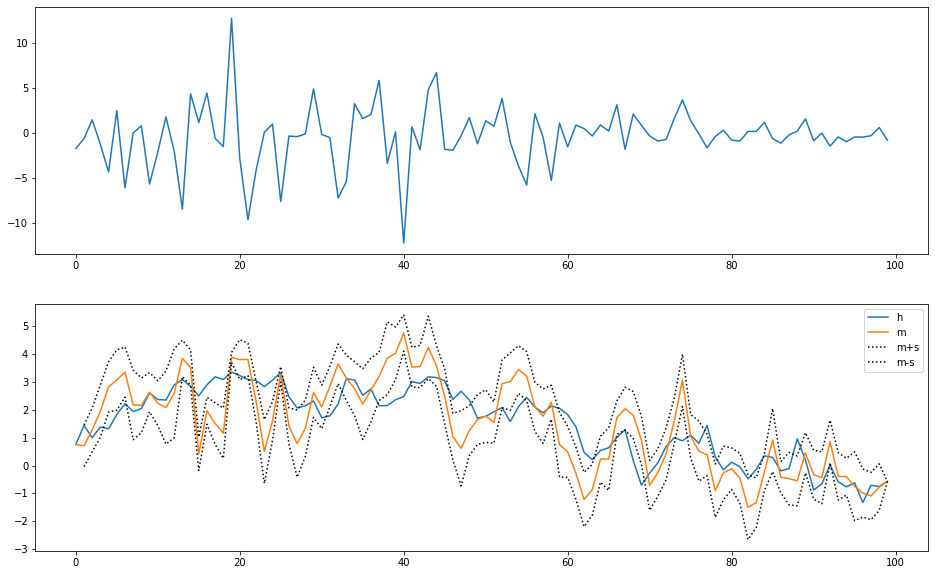

Acceptance rate:  0.347


In [23]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
estsv.py

Purpose:
    Estimate a simple SV model, only for the volatility sequence

Version:
    1       First start
    outline Only outline, missing the most importance sampling part...

Date:
    2019/11/21

Author:
    Charles Bos
"""
import matplotlib.pyplot as plt

###########################################################
### (vY, vH)= GenrSV(vTheta, iT)
def GenrSV(vTheta, iT):
    """
    Purpose:
        Generate SV data

    Inputs:
        vTheta      vector, parameters (dMu, dGamma, dPhi, dSXi)
        iT          integer, number of observations

    Return value:
        vY          iT vector, observations
        vH          iT vector, volatility (excluding gamma)
    """
    (dMu, dGamma, dPhi, dSXi)= vTheta
    vY= np.zeros(iT)
    vH= np.zeros(iT)

    dH= np.random.randn() * dSXi / np.sqrt(1-dPhi*dPhi)
    for i in range(iT):
        vH[i]= dH
        vY[i]= dMu + np.exp(0.5*(dH + dGamma))*np.random.randn()
        dH= dPhi * dH + dSXi * np.random.randn()


    return (vY, vH)

###########################################################
### iA= SampleH1(vY, vH, vTheta, t)
def SampleH1(vY, vH, vTheta, t, *fns):
    """
    Purpose:
        Sample a single h, given the information before/after

    Inputs:
        vY          iT vector, observations
        vH          iT vector, volatility (excluding gamma)
        vTheta      vector, parameters (dMu, dGamma, dPhi, dSXi)
        t           integer, observation h to sample

    Output:
        vH          iT vector, volatility (excluding gamma), with h[t] changed

    Return value:
        iA          integer, if 1 draw was accepted, 0 otherwise
    """
    (dMu, dGamma, dPhi, dSXi)= vTheta
    
    # Fill in your code...
    iA = 0
        

    candidate_h_sampler, compute_acc_prob = fns

    previous_h = vH[t-1]
    next_h = vH[t+1]
    
    current_y = vY[t]
    current_h = vH[t]

    candidate_h, jumping_mean = candidate_h_sampler(previous_h, next_h, current_y)
    
    prob_acceptance = compute_acc_prob(candidate_h, current_h, current_y, jumping_mean)
    
    accept = np.random.uniform() < prob_acceptance
    iA = int(accept)
    
    if accept:
        vH[t] = candidate_h
    
    return iA

###########################################################
### dA= SampleH(vY, vH, vTheta)
def SampleH(vY, vH, vTheta, *fns):
    """
    Purpose:
        Sample a vector of h, given the parameters and data

    Inputs:
        vY          iT vector, observations
        vH          iT vector, volatility (excluding gamma)
        vTheta      vector, parameters (dMu, dGamma, dPhi, dSXi)

    Output:
        vH          iT vector, volatility (excluding gamma), with all interior elements changed

    Return value:
        dA          double, fractions of draws accepted
    """
    iA= 0
    iT= vY.shape[0]

    for t in range(1, iT-1):
        iA+= SampleH1(vY, vH, vTheta, t, *fns)

    return iA/(iT-2)

###########################################################
### (mMS, dA)= SampleHS(vY, vH0, vTheta, iS)
def SampleHS(vY, vH0, vTheta, iS, *fns):
    """
    Purpose:
        Sample a vector of h, given the parameters and data, S times

    Inputs:
        vY          iT vector, observations
        vH0         iT vector, initial volatility (excluding gamma)
        vTheta      vector, parameters (dMu, dGamma, dPhi, dSXi)
        iS          integer, number of repetitions

    Return value:
        mMS         2 x iT matrix, mean and standard deviations of sampled h values
        dA          double, fractions of draws accepted
    """
    iT= vY.shape[0]
    vH= np.copy(vH0)
    mMS= np.zeros((2, iT))
    dA= 0
    for s in range(iS):
        print(f'Sampling... {s + 1}/{iS}', end='\r')
        dA+= SampleH(vY, vH, vTheta, *fns)
        mMS[0]+= vH
        mMS[1]+= vH**2

    # Get means/standard deviations
    dA/= iS
    mMS/= iS
    mMS[1]= np.sqrt(mMS[1] - mMS[0]**2)

    return (mMS, dA)

###########################################################
### Output(vY, vH0, mMS, dA, iS)
def Output(vY, vH0, mMS, dA, iS):
    """
    Purpose:
        Show output on sample

    Inputs:
        vY
    """
    iT= vY.shape[0]
    plt.figure(figsize=(16,10))
    plt.subplot(2,1,1)
    plt.plot(vY)
    plt.subplot(2,1,2)
    plt.plot(vH0, label='h')
    plt.plot(mMS[0], label='m')
    plt.plot(mMS[0]+mMS[1], 'k:', label='m+s')
    plt.plot(mMS[0]-mMS[1], 'k:', label='m-s')
    plt.legend()
    # plt.savefig('graphs/sampleht%is%i.png' % (iT, iS))
    plt.show()

    print ("Acceptance rate: %6.3f" % dA)


###########################################################
### main
def main():
    # Magic numbers
    vTheta= [0, 0, .95, .5]
    iT= 100
    iSeed= 1234
    iS= 1_000

    # Initialisation
    np.random.seed(iSeed)
    (vY, vH0)= GenrSV(vTheta, iT)
    

    # Estimation
    candidate_h_sampler, target = factory_sampler(vTheta)
    
    start = time()
    (mMS, dA)= SampleHS(vY, vH0, vTheta, iS, candidate_h_sampler, target)
    
    print('Done in ', time() - start)
    

    # Output
    Output(vY, vH0, mMS, dA, iS)

###########################################################
### start main
if __name__ == "__main__":
    main()
